In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing  import LabelEncoder

import tensorflow_datasets as tfds
import tensorflow as tf

from tensorflow.python.keras.layers import Dense
from tensorflow.python.keras.layers import Dropout
from tensorflow.python.keras.layers import Embedding
from tensorflow.python.keras.layers import Conv1D
from tensorflow.python.keras.layers import MaxPooling1D
from tensorflow.python.keras.layers import Lambda
from tensorflow.python.keras.layers import GlobalAveragePooling1D
from keras.layers import Input, Embedding, LSTM, Dense, merge
from keras import backend as K

tfds.disable_progress_bar()

In [2]:
import matplotlib.pyplot as plt


def plot_graphs(history, metric):
  plt.plot(history.history[metric])
  plt.plot(history.history['val_'+metric], '')
  plt.xlabel("Epochs")
  plt.ylabel(metric)
  plt.legend([metric, 'val_'+metric])

In [3]:
# load Dataset1.
url_data = pd.read_csv('urldata.csv')
url_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 450176 entries, 0 to 450175
Data columns (total 4 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   Unnamed: 0  450176 non-null  int64 
 1   url         450176 non-null  object
 2   label       450176 non-null  object
 3   result      450176 non-null  int64 
dtypes: int64(2), object(2)
memory usage: 13.7+ MB


In [4]:
url_data.head()

,Unnamed: 0,url,label,result
0,0,https://www.google.com,benign,0
1,1,https://www.youtube.com,benign,0
2,2,https://www.facebook.com,benign,0
3,3,https://www.baidu.com,benign,0
4,4,https://www.wikipedia.org,benign,0


In [5]:
number = LabelEncoder()
url_data['label'] = number.fit_transform(url_data['label'].astype(str))
url_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 450176 entries, 0 to 450175
Data columns (total 4 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   Unnamed: 0  450176 non-null  int64 
 1   url         450176 non-null  object
 2   label       450176 non-null  int64 
 3   result      450176 non-null  int64 
dtypes: int64(3), object(1)
memory usage: 13.7+ MB


In [6]:
train, test = train_test_split(url_data, test_size=0.2)
train, val = train_test_split(train, test_size=0.2)

train.to_csv('train.csv', header=False)
test.to_csv('test.csv', header=False)

In [7]:
BUFFER_SIZE = 10000
BATCH_SIZE = 64
types  = [tf.string, tf.int64]
record_defaults = ['XXXX', 999] # Only provide defaults for the selected columns

In [8]:
train_dataset = tf.data.experimental.CsvDataset("train.csv", record_defaults, select_cols=[2, 3])
train_dataset.element_spec
train_dataset

<CsvDatasetV2 shapes: ((), ()), types: (tf.string, tf.int32)>

In [9]:
test_dataset = tf.data.experimental.CsvDataset("test.csv", record_defaults, select_cols=[2, 3])
test_dataset.element_spec

(TensorSpec(shape=(), dtype=tf.string, name=None),
 TensorSpec(shape=(), dtype=tf.int32, name=None))

In [10]:
train_dataset = train_dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
test_dataset = test_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)


In [11]:
train_dataset.element_spec

(TensorSpec(shape=(None,), dtype=tf.string, name=None),
 TensorSpec(shape=(None,), dtype=tf.int32, name=None))

In [12]:
for url, label in train_dataset.take(1):
    print('ursl: ', url.numpy()[:3])
    print()
    print('labels: ', label.numpy()[:3])

ursl:  [b'https://www.en.goldenmap.com/Ahuntsic-Cartierville'
 b'https://www.drivingschoolmontreal.com/DrivingSchoolMontreal_Car_Rental_For_SAAQ_Langelier.html'
 b'https://www.brr.com.au/event/82765/grant-anderson-partner']

labels:  [0 0 0]


In [13]:
VOCAB_SIZE = 1000
encoder = tf.keras.layers.experimental.preprocessing.TextVectorization(
    max_tokens=VOCAB_SIZE)
encoder.adapt(train_dataset.map(lambda url, label: url))

In [14]:
vocab = np.array(encoder.get_vocabulary())
vocab[:20]

array(['', '[UNK]', 'httpmobilapps',
       'httpwwwkf25zxcomimageshttpusbattlenetlogin',
       'httpwwwkf25zxcomimageshttpusbattlenetloginen', 'httpsmstrust',
       'httpsecurityapps', 'httpomnitrust',
       'httpkf25zxcomimagesusbattlenet',
       'httpwwwkf25zxcomimagesusbattlenet', 'httpsmstrust2fh',
       'httpkf25zxcomimagesusbattlenetlogin', 'httphyhpzxcnjshttp',
       'httphanhaicleancnjshttpusbattlenetloginenrefhttpyfvgqexusbattlenetd3enindexampappcomd3',
       'httpappsmobile2fh', 'httpysgrpcomcnjsusbattlenetloginenrefhttp',
       'httpxjbctckycomimagesappcomd3ampusbattlenetloginenrefhttpusbattlenet',
       'httpstuffatwebcomsigninsurveysiiphpemail',
       'httpmihesfitonsruslivagatephp',
       'httpkf25zxcomimageshttpusbattlenetloginenrefhttpalvtdlkusbattlenetd3enindexampamp'],
      dtype='<U641')

In [15]:
encoded_url = encoder(url)[:3].numpy()
encoded_url

array([[1, 0],
       [1, 0],
       [1, 0]])

In [16]:
for n in range(3):
    print("Original: ", url[n].numpy())
    print("Round-trip: ", " ".join(vocab[encoded_url[n]]))
    print()

Original:  b'https://www.en.goldenmap.com/Ahuntsic-Cartierville'
Round-trip:  [UNK] 

Original:  b'https://www.drivingschoolmontreal.com/DrivingSchoolMontreal_Car_Rental_For_SAAQ_Langelier.html'
Round-trip:  [UNK] 

Original:  b'https://www.brr.com.au/event/82765/grant-anderson-partner'
Round-trip:  [UNK] 



In [17]:
def sum_1d(X):
    return K.sum(X, axis=1)


In [18]:
main_input = Input(shape=(200,), dtype='int32', name='main_input')
input_shape=(1000,1)

model = tf.keras.Sequential([
    encoder,
    tf.keras.layers.Embedding(
                    output_dim=200,
                    input_dim=1000,
                    mask_zero=True),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Conv1D(filters=256,
                          kernel_size=2,
                          activation='relu',
                          bias_initializer='random_uniform',
                          padding='same'),
    tf.keras.layers.Lambda(sum_1d),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(1)
])

In [19]:
#   tf.keras.layers.Conv1D(filters=256,
#                           kernel_size=4,
#                           activation='relu',
#                           bias_initializer='random_uniform',
#                           padding='same'),
#     tf.keras.layers.Lambda(sum_1d),
#     tf.keras.layers.Dropout(0.5),
#     tf.keras.layers.Conv1D(filters=256,
#                           kernel_size=5,
#                           activation='relu',
#                           bias_initializer='random_uniform',
#                           padding='same'),
#     tf.keras.layers.Lambda(sum_1d),
#     tf.keras.layers.Dropout(0.5,
#                           input_shape=input_shape),

In [20]:
print([layer.supports_masking for layer in model.layers])

[False, True, True, False, True, True, True, True]


In [21]:
sample_url = ('https://www.jumbovideo.com/')
predictions = model.predict(np.array([sample_url]))
print(predictions[0])

[-0.01207657]


In [22]:
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer=tf.keras.optimizers.Adam(1e-4),
              metrics=['accuracy'])

In [23]:
history = model.fit(train_dataset, epochs=3, validation_data=test_dataset)

Epoch 1/3
4502/4502 [==============================] - 54s 11ms/step - loss: 0.5477 - accuracy: 0.7688 - val_loss: 0.5433 - val_accuracy: 0.7667
Epoch 2/3
4502/4502 [==============================] - 35s 8ms/step - loss: 0.5358 - accuracy: 0.7743 - val_loss: 0.5437 - val_accuracy: 0.7671
Epoch 3/3
4502/4502 [==============================] - 35s 8ms/step - loss: 0.5335 - accuracy: 0.7750 - val_loss: 0.5426 - val_accuracy: 0.7671


(0.0, 0.5442453354597092)

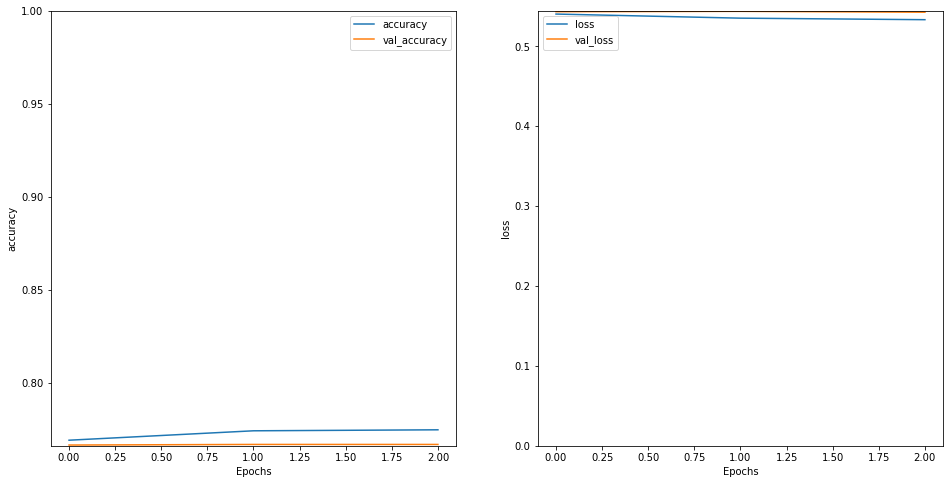

In [24]:
plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
plot_graphs(history, 'accuracy')
plt.ylim(None, 1)
plt.subplot(1, 2, 2)
plot_graphs(history, 'loss')
plt.ylim(0, None)